In [72]:
# data manipulation
import numpy as np
import pandas as pd

#file processing / requests
from pathlib import Path
from tqdm import tqdm
import json
import urllib

#computer vision
import cv2
import torch
import torchvision

import PIL

#ML
from sklearn.model_selection import train_test_split


#display
from IPython.display import display
from pylab import rcParams

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import PIL.Image as Image

#utils2.py package can be found under https://github.com/philippe-heitzmann/Object_Detection
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)


### Notebook Purpose: Perform unsupervised clustering on dataset of credit card transaction behaviors of ~9000 customers taken from following Kaggle competition https://www.kaggle.com/arjunbhasin2013/ccdata/version/1

Notebook authors: Philippe Heitzmann

In [4]:
!pip install spacy nltk gensim textblob bokeh imutils pytesseract plotly hdbscan

     |████████████████████████████████| 24.1 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 636 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 18.5 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 27.7 MB 6.8 MB/s eta 0:00:01     |███████████████████████         | 19.9 MB 6.4 MB/s eta 0:00:02


In [5]:
#utils2.py package can be found under https://github.com/philippe-heitzmann/Object_Detection
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

In [133]:
df = readcsv('CC GENERAL.csv')
df.head()

0.0 sec to complete <function readcsv at 0x7fabdf434a60>


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
#The sample Dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.
show1(df)
print(df['CUST_ID'].nunique())

(8950, 18) <class 'pandas.core.frame.DataFrame'>
8950


#### Given this is an unsupervised ML problem, what question do we really want to answer?

1. General segmentation: How can we best describe and segment our credit card customer base by their demographic and financial profile in order to better tailor our marketing messaging to these different groups? 

1. Segmentation by frequency of transactions and total number of transactions: how can we segment our customers by frequency of transactions and total number of transactions of different types to deliver differentiated marketing treatments to each?

1. Segmentation by transaction amounts: how can we segment our customers by amounts of transactions of different types to deliver differentiated marketing treatments to each?

###### Amounts of Purchases done by user
- ONEOFF_PURCHASES
- INSTALLMENTS_PURCHASES
- PURCHASES
- CASH_ADVANCE
- PAYMENTS
- MINIMUM_PAYMENTS
- CREDIT_LIMIT
- BALANCE

### Counts / Frequencies of Transactions
- PURCHASES_FREQUENCY
- PURCHASES_TRX CASH_ADVANCE_TRX
- PURCHASES_INSTALLMENTS_FREQUENCY 
- ONEOFF_PURCHASES_FREQUENCY
- CASH_ADVANCE_FREQUENCY
- CASH_ADVANCE_TRX
- PRC_FULL_PAYMENT
- BALANCE_FREQUENCY

### Demographic
- TENURE

### Misc
- CUSTID

#### Potential supervised ML question: how can we predict CREDIT_LIMIT from other variables?

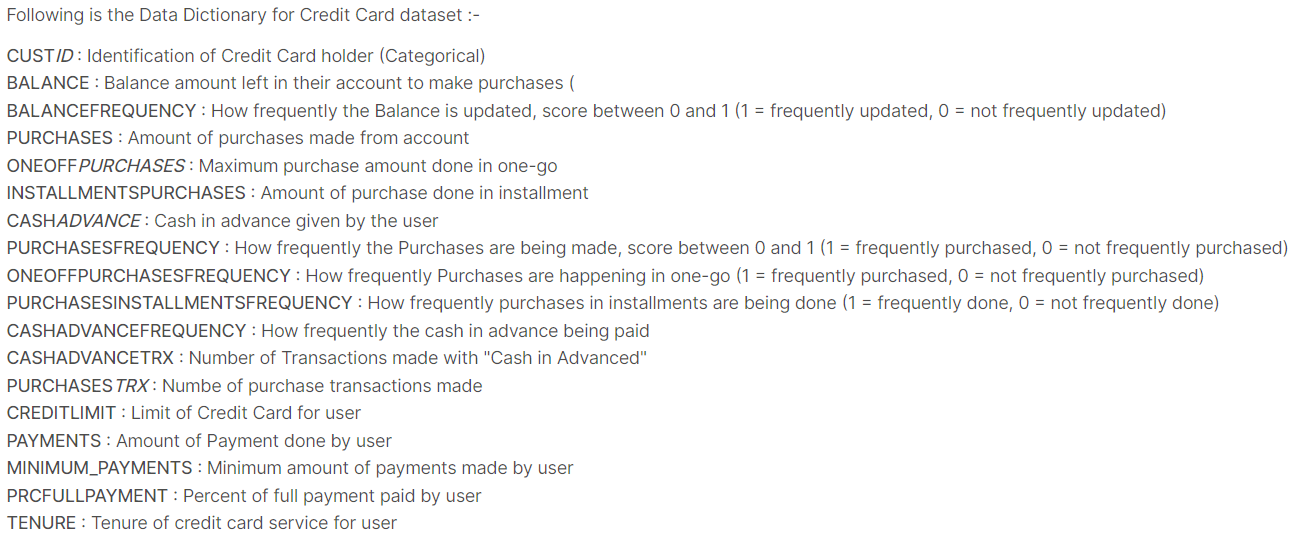

In [11]:
#data dictionary
from IPython.display import Image
Image(filename='Credit_Card_DD.png') 

### Data Preprocessing

#### Step 1: Data cleaning and missing value imputation

In [16]:
#checking nulls
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [22]:
#looking at differences in customers with MINIMUM_PAYMENTS missing values versus customers without 
df.loc[df['MINIMUM_PAYMENTS'].isnull()].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,0.0,313.0,313.000000
mean,555.441321,0.389403,393.087284,250.433387,142.653898,559.136698,0.336043,0.107886,0.244670,0.067169,1.460064,5.833866,3731.789137,322.286168,NaN,0.0,11.063898
std,1292.687887,0.408341,757.905701,624.453991,311.289043,1185.132567,0.372517,0.227370,0.359756,0.130087,3.182359,9.600908,2924.606153,1996.658905,NaN,0.0,1.869734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,NaN,0.0,6.000000
25%,0.187069,0.090909,1.400000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,0.000000,NaN,0.0,12.000000
50%,16.848358,0.181818,130.400000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,2.000000,3000.000000,0.000000,NaN,0.0,12.000000
75%,286.686616,1.000000,399.950000,176.030000,152.280000,480.104401,0.583333,0.083333,0.416667,0.083333,1.000000,8.000000,5000.000000,0.000000,NaN,0.0,12.000000
max,9164.724752,1.000000,7597.090000,6761.290000,2959.240000,7616.064965,1.000000,1.000000,1.000000,1.000000,21.000000,77.000000,19500.000000,29272.486070,NaN,0.0,12.000000


In [23]:
df.loc[~df['MINIMUM_PAYMENTS'].isnull()].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8637.000000,8636.000000,8637.000000,8637.000000,8637.000000,8637.00000
mean,1601.041632,0.894951,1025.315149,604.831402,420.794807,994.082050,0.495943,0.205885,0.368778,0.137608,3.313651,15.031492,4522.091030,1784.272537,864.206542,0.159285,11.53375
std,2095.519182,0.207833,2167.010602,1684.222861,917.203254,2121.353259,0.401285,0.300044,0.398090,0.201780,6.912151,25.179530,3659.240379,2909.704331,2372.446607,0.296259,1.31226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.00000
25%,147.838347,0.909091,43.300000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,418.446951,169.123707,0.000000,12.00000
50%,916.749476,1.000000,375.240000,44.990000,94.710000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,896.300688,312.343947,0.000000,12.00000
75%,2104.961701,1.000000,1145.850000,598.950000,484.040000,1131.986387,0.916667,0.333333,0.750000,0.250000,4.000000,18.000000,6500.000000,1951.116757,825.485459,0.166667,12.00000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.00000


In [26]:
df.shape[0] - df.loc[df['MINIMUM_PAYMENTS'] > 0].shape[0]

313

#### How do we impute MINIMUM_PAYMENTS?
Looking at mean differences in independent variables other than MINIMUM_PAYMENTS to devise optimal imputation strategy for the latter, it appears 
customers with missing MINIMUM_PAYMENTS values are on the whole lower-spend and lower card activity customers with for instance:

- lower total payment amounts (PURCHASES  variable)
- lower total payments (PAYMENTS variable)
- lower card balances (BALANCE variable) 
- lower frequency of updates to balances (BALANCE_FREQUENCY)
- lower amounts in other types of purchases (ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES)
- On the other hand, these customers appear to follow a similar distribution in tenure (11.5 vs 11.8 averages with ~1.5 standard deviations). 

Furthermore considering that PRC_FULL_PAYMENT is zero for all these non-missing value customers and that the number 
of missing values is equal to the difference in our count of observations minus the number of non-missing values that are greater than zero, it should therefore be expected
that these missing MINIMUM_PAYMENTS values actually point to zero, which is how we will impute these values in the next line:

In [135]:
#imputing missing MINIMUM_PAYMENTS values to zero
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(0)

In [137]:
df.loc[df['CREDIT_LIMIT'].isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [138]:
df.groupby('TENURE')['CREDIT_LIMIT'].mean()

TENURE
6     3002.561576
7     2567.631579
8     2973.724490
9     2977.904762
10    3871.610169
11    4141.232877
12    4693.331329
Name: CREDIT_LIMIT, dtype: float64

In [139]:
#Given it appears credit limit varies quite a bit with tenure with <10 years tenure customers posting credit limits <$3K on the whole vs ~$4K for >10y, and given our own 
#industry knowledge regarding the impact of tenure on offered credit limits, we will choose to impute this missing credit limit value to the mean 

#imputing missing CREDIT_Limit value to mea of $3,000 for <10y tenure customers
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(3000)

#### Step 2: Outlier Treatment

In [60]:
#getting list of indices of all potential outlier values for each of our df columns
outlier_idx_dict = get_outliers(df)
outlier_idx_dict['BALANCE'][:5]

0.0 sec to complete <function get_outliers at 0x7faced0ec0d0>


[15, 21, 24, 28, 30]

In [101]:
#utils2.py package can be found under https://github.com/philippe-heitzmann/Object_Detection
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

def get_col_stats(*cols, df, maxval = 10000, **kwargs):
    for col in cols:
        q1, q2, q3, iqr, low_outlier_threshold, high_outlier_threshold, min_, max_ = get_stats(col, df = df)
        print('Outlier low and high thresholds:', low_outlier_threshold, high_outlier_threshold)
        print(f'{col} min and max values:', min_, max_)
        print('Number of detected potential outliers:', len(outlier_idx_dict[col]), 'or', np.round(len(outlier_idx_dict[col]) / df.shape[0] * 100, 1), '% of dataset values')
        print(f'Number of values greater than {maxval}: ',df.loc[df[col] > maxval].shape[0])
        viz0 = Viz(df=df, figsize = (7,4))
        viz0.make_hist(col, num_bins = 100, **kwargs)

Outlier low and high thresholds: -1566.1075000000003 2715.8725000000004
PURCHASES min and max values: 0.0 49039.57
Number of detected potential outliers: 808 or 9.0 % of dataset values
Number of values greater than 30000:  7
Initiated with figsize (7, 4)


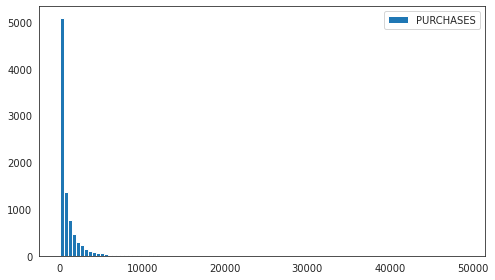

In [102]:
get_col_stats('PURCHASES', df = df, maxval = 30000)

#considering PURCHASES represents amount of purchases made from account in last 6 months, as it should theoretically be possible to have $50K in credit card purchases 
#in a six month period, we will elect not to treat these PURCHASES outlier values for now  

Outlier low and high thresholds: -866.1075 1443.5124999999998
ONEOFF_PURCHASES min and max values: 0.0 40761.25
Number of detected potential outliers: 1013 or 11.3 % of dataset values
Number of values greater than 10000:  39
Initiated with figsize (7, 4)


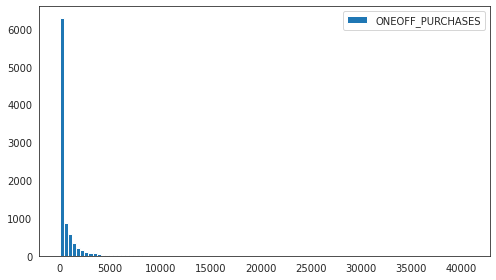

In [103]:
#utils2.py package can be found under https://github.com/philippe-heitzmann/Object_Detection
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

get_col_stats('ONEOFF_PURCHASES', df = df, maxval = 10000)

#considering ONEOFF_PURCHASES represents Maximum purchase amount done in one-go in last 6 months, as it should theoretically be possible to have $10-$40K in total oneoff credit card
#purchases in a six month period, we will elect not to treat these ONEOFF_PURCHASES outlier values for now  

Outlier low and high thresholds: -702.95625 1171.59375
INSTALLMENTS_PURCHASES min and max values: 0.0 22500.0
Number of detected potential outliers: 867 or 9.7 % of dataset values
Number of values greater than 10000:  12
Initiated with figsize (7, 4)


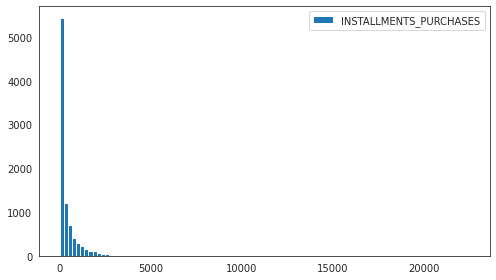

In [104]:
#utils2.py package can be found under https://github.com/philippe-heitzmann/Object_Detection
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

get_col_stats('INSTALLMENTS_PURCHASES', df = df)
#considering INSTALLMENTS_PURCHASES represents Amount of purchase done in installment in last 6 months, as it should theoretically be possible to have $10-$25K in total 
#installment purchases in a six month period, we will elect not to treat these INSTALLMENTS_PURCHASES outlier values for now  

Outlier low and high thresholds: -1670.7317088750003 2784.5528481250003
CASH_ADVANCE min and max values: 0.0 47137.21176
Number of detected potential outliers: 1030 or 11.5 % of dataset values
Number of values greater than 10000:  77
Initiated with figsize (7, 4)


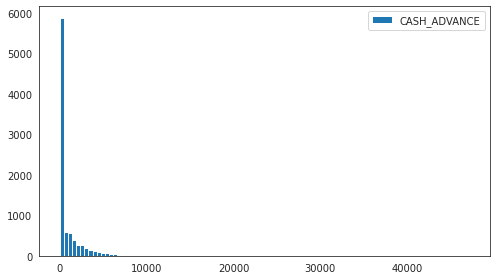

In [105]:
get_col_stats('CASH_ADVANCE', df = df)

In [106]:
#seems high but possible - keep in dataset for now
df.loc[df['CASH_ADVANCE'] > 46000]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


In [108]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4493.947277,1733.143852,833.983453,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.922543,2895.063757,2335.989918,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,163.028164,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,289.628402,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,788.713501,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Outlier low and high thresholds: -0.333333 0.555555
CASH_ADVANCE_FREQUENCY min and max values: 0.0 1.5
Number of detected potential outliers: 525 or 5.9 % of dataset values
Number of values greater than 10000:  0
Initiated with figsize (7, 4)


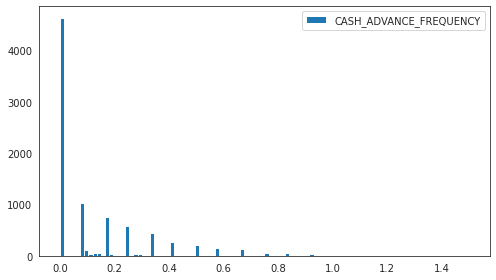

In [109]:
get_col_stats('CASH_ADVANCE_FREQUENCY', df = df)

In [114]:
#these values should not be possible given CASH_ADVANCE_FREQUENCY should vary between 0 and 1. We will therefore winsorize these to 0 
df.loc[df['CASH_ADVANCE_FREQUENCY'] > 1]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
681,C10708,5656.069801,1.000000,362.36,362.36,0.0,7240.433194,0.250000,0.250000,0.0,1.250000,12,2,8000.0,683.421497,2036.877611,0.0,8
1626,C11680,2876.009336,1.000000,152.61,152.61,0.0,3719.650168,0.333333,0.333333,0.0,1.166667,24,2,4000.0,248.342971,584.926336,0.0,6
2555,C12629,5906.184924,1.000000,141.80,141.80,0.0,1651.286918,0.125000,0.125000,0.0,1.125000,12,2,10000.0,933.969974,919.289675,0.0,8
2608,C12684,7801.511533,1.000000,231.40,231.40,0.0,4109.465221,0.100000,0.100000,0.0,1.100000,20,3,13500.0,1593.617739,1522.496755,0.0,10
3038,C13127,3846.742530,1.000000,0.00,0.00,0.0,1932.460679,0.000000,0.000000,0.0,1.500000,18,0,5600.0,496.245836,538.346874,0.0,6
3253,C13347,5709.486507,0.833333,0.00,0.00,0.0,2794.326341,0.000000,0.000000,0.0,1.166667,10,0,6000.0,550.513331,1299.463370,0.0,6
8055,C18273,1917.895730,1.000000,285.07,285.07,0.0,6084.858872,0.363636,0.363636,0.0,1.090909,28,6,3000.0,5692.682993,556.449635,0.0,11
8365,C18588,3857.562230,1.000000,0.00,0.00,0.0,2127.213754,0.000000,0.000000,0.0,1.142857,26,0,5000.0,617.508991,538.396872,0.0,7


In [116]:
idxs = df.loc[df['CASH_ADVANCE_FREQUENCY'] > 1].index
for idx in idxs:
    df.iloc[idx, 10] = 1
df.loc[df['CASH_ADVANCE_FREQUENCY'] > 1]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE


Outlier low and high thresholds: -6.0 10.0
CASH_ADVANCE_TRX min and max values: 0.0 123.0
Number of detected potential outliers: 804 or 9.0 % of dataset values
Number of values greater than 100:  5
Initiated with figsize (7, 4)


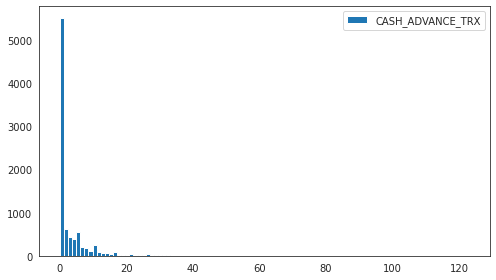

In [118]:
get_col_stats('CASH_ADVANCE_TRX', df = df, maxval = 100)

In [119]:
df.loc[df['CASH_ADVANCE_TRX'] > 100]
#as a max of 123 cash advances transactions in a xis month possible would be theoretically possible at a rate of one such txn every 1.5 days on average, will
#elect not to treat these for now

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
542,C10566,1284.633140,1.000000,55.50,0.0,55.50,5406.459348,0.083333,0.000000,0.083333,0.833333,123,1,3000.0,3432.757202,421.385587,0.000000,12
1913,C11975,1856.325339,0.818182,670.50,516.9,153.60,5603.126858,0.545455,0.272727,0.363636,0.727273,107,9,7000.0,9221.922948,537.180986,0.142857,11
2159,C12226,10905.053810,1.000000,431.93,133.5,298.43,47137.211760,0.583333,0.250000,0.500000,1.000000,123,21,19600.0,39048.597620,5394.173671,0.000000,12
3545,C13645,4175.826879,1.000000,0.00,0.0,0.00,9968.184827,0.000000,0.000000,0.000000,0.909091,110,0,10500.0,1083.433387,1000.206323,0.000000,11
8315,C18536,2648.244646,1.000000,0.00,0.0,0.00,10458.978150,0.000000,0.000000,0.000000,1.000000,123,0,4000.0,9818.531412,665.888853,0.000000,12


Outlier low and high thresholds: -23.0 41.0
PURCHASES_TRX min and max values: 0.0 358.0
Number of detected potential outliers: 766 or 8.6 % of dataset values
Number of values greater than 300:  5
Initiated with figsize (7, 4)


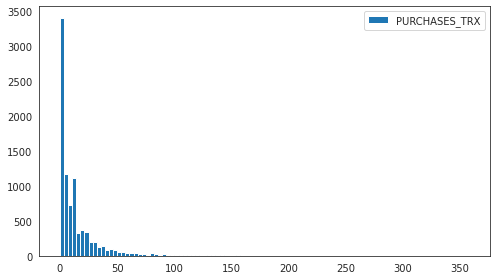

In [121]:
get_col_stats('PURCHASES_TRX', df = df, maxval = 300)

Outlier low and high thresholds: -5750.0 13850.0
CREDIT_LIMIT min and max values: 0.0 30000.0
Number of detected potential outliers: 248 or 2.8 % of dataset values
Number of values greater than 25000:  3
Initiated with figsize (7, 4)


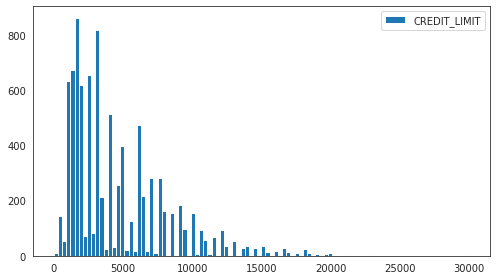

In [123]:
get_col_stats('CREDIT_LIMIT', df = df, maxval = 25000)
#credit limit >$25K theoretically possible, will elect not to treat for now 

Outlier low and high thresholds: -1893.5110601250003 4177.921542875
PAYMENTS min and max values: 0.0 50721.48336
Number of detected potential outliers: 808 or 9.0 % of dataset values
Number of values greater than 10000:  171
Initiated with figsize (7, 4)


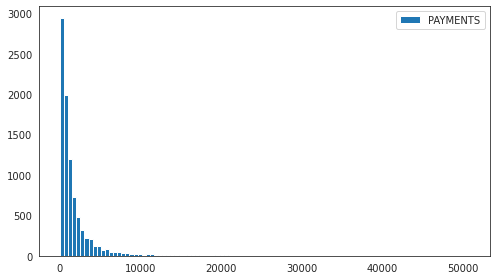

In [124]:
get_col_stats('PAYMENTS', df = df)

Outlier low and high thresholds: -775.4998417500001 1727.24150625
MINIMUM_PAYMENTS min and max values: 0.0 76406.20752
Number of detected potential outliers: 899 or 10.0 % of dataset values
Number of values greater than 25000:  18
Initiated with figsize (7, 4)


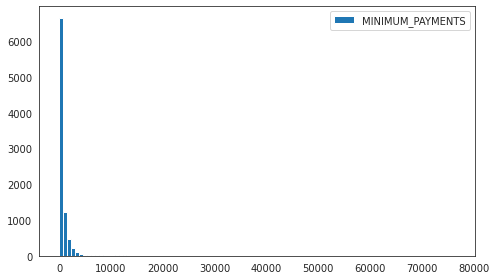

In [128]:
get_col_stats('MINIMUM_PAYMENTS', df = df, maxval = 25000)

Outlier low and high thresholds: 12.0 12.0
TENURE min and max values: 6.0 12.0
Number of detected potential outliers: 1366 or 15.3 % of dataset values
Number of values greater than 10000:  0
Initiated with figsize (7, 4)


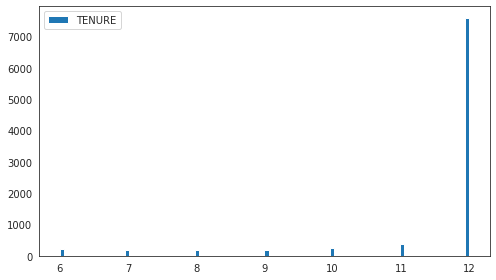

In [129]:
get_col_stats('TENURE', df = df)

### Feature Engineering

#Features to engineer

- ONEOFF_PURCHASES / PURCHASES
- INSTALLMENTS_PURCHASES / PURCHASES
- MINIMUM_PAYMENTS / PAYMENTS
- PURCHASES / PURCHASES_TRX
- CASH_ADVANCE / CASH_ADVANCE_TRX

In [161]:
df['ONEOFF_PURCHASES/PURCHASES'] = df['ONEOFF_PURCHASES'] / df['PURCHASES']
df['INSTALLMENTS_PURCHASES/PURCHASES'] = df['INSTALLMENTS_PURCHASES'] / df['PURCHASES']
df['MINIMUM_PAYMENTS/PAYMENTS'] = df['MINIMUM_PAYMENTS'] / df['PAYMENTS']
df['Average_Purchase_Amount'] = df['PURCHASES'] / df['PURCHASES_TRX']
df['Average_Cash_Advance_Amount'] = df['CASH_ADVANCE'] / df['CASH_ADVANCE_TRX']

In [171]:
print(df.loc[(df['ONEOFF_PURCHASES/PURCHASES'].isna()) & (df['PURCHASES'] == 0)].shape[0])
print(df.loc[(df['INSTALLMENTS_PURCHASES/PURCHASES'].isna()) & (df['PURCHASES'] == 0)].shape[0])
print(df.loc[(df['MINIMUM_PAYMENTS/PAYMENTS'].isna()) & (df['PAYMENTS'] == 0)].shape[0])
print(df.loc[(df['Average_Purchase_Amount'].isna()) & (df['PURCHASES_TRX'] == 0)].shape[0])
print(df.loc[(df['Average_Cash_Advance_Amount'].isna()) & (df['CASH_ADVANCE_TRX'] == 0)].shape[0])

2044
2042
240
2041
4628


In [172]:
#imputing below to zero given caused by division by zero erros 
df['ONEOFF_PURCHASES/PURCHASES'] = df['ONEOFF_PURCHASES/PURCHASES'].fillna(0)
df['INSTALLMENTS_PURCHASES/PURCHASES'] = df['INSTALLMENTS_PURCHASES/PURCHASES'].fillna(0)
df['MINIMUM_PAYMENTS/PAYMENTS'] = df['MINIMUM_PAYMENTS/PAYMENTS'].fillna(0)
df['Average_Purchase_Amount'] = df['Average_Purchase_Amount'].fillna(0)
df['Average_Cash_Advance_Amount'] = df['Average_Cash_Advance_Amount'].fillna(0)

### EDA

In [ ]:
DISTRIBUTION OF FREQUENCY VARIABLES - PURCHASES_FREQUENCY & PURCHASES_INSTALLMENTS_FREQUENCY & ONEOFF_PURCHASES_FREQUENCY & CASH_ADVANCE_FREQUENCY & BALANCE_FREQUENCY

PURCHASES_TRX vs PURCHASES_FREQUENCY
PURCHASES_TRX vs PURCHASES_INSTALLMENTS_FREQUENCY

ONEOFF_PURCHASES_FREQUENCY vs ONEOFF_PURCHASES

PURCHASES_FREQUENCY vs PURCHASES_INSTALLMENTS_FREQUENCY & ONEOFF_PURCHASES_FREQUENCY & CASH_ADVANCE_FREQUENCY & BALANCE_FREQUENCY
PURCHASES_TRX CASH_ADVANCE_TRX

CREDIT_LIMIT vs TENURE
CREDIT_LIMIT vs BALANCE
CREDIT_LIMIT vs PURCHASES
CREDIT_LIMIT vs CASH_ADVANCE
CREDIT_LIMIT vs PAYMENTS

### Clustering

In [142]:
df.drop(['CUST_ID'], axis = 1, inplace = True)

In [188]:
infmask = np.isinf(X)
df.loc[infmask]

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,ONEOFF_PURCHASES/PURCHASES,INSTALLMENTS_PURCHASES/PURCHASES,MINIMUM_PAYMENTS/PAYMENTS,Average_Purchase_Amount,Average_Cash_Advance_Amount
1458,4.382924,0.272727,130.24,0.00,152.24,0.0,0.083333,0.000000,0.083333,0.0,0,0,14000.0,28988.973880,1092.184812,0.500000,12,0.0,1.168919,0.037676,inf,0.0
3590,1.869435,0.454545,0.24,0.24,0.00,0.0,0.083333,0.083333,0.000000,0.0,0,0,3000.0,150.381107,53.294711,0.000000,12,1.0,0.000000,0.354398,inf,0.0
4497,72.425884,1.000000,655.68,0.00,655.68,0.0,1.000000,0.000000,1.000000,0.0,0,0,1000.0,718.537117,162.732686,0.333333,12,0.0,1.000000,0.226478,inf,0.0


In [189]:
df['INSTALLMENTS_PURCHASES/PURCHASES'].replace([np.inf, -np.inf], 1, inplace=True)
df['Average_Purchase_Amount'].replace([np.inf, -np.inf], 0, inplace=True)

In [190]:
from sklearn.preprocessing import StandardScaler
X = np.asarray(df)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(8950, 22)

In [200]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

fig, intertia = get_elbow_plot(X, start = 1, end = 11, elbow_annot = 4, random_state = 42)
fig

In [205]:
import sys
sys.path.append('/Users/Administrator/DS/DeepRoad/Object_Detection')
sys.path.append('/Users/phil0/DS/DeepRoad/Object_Detection')
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

In [206]:
fig, polar, clusters, scaler = get_kmeans(data = df, cols = list(df.columns), n_clusters = 4, random_state = 42)
fig

0.8 sec to complete <function get_kmeans at 0x7fabe8fefee0>


In [ ]:
print(df.loc[df['MINIMUM_PAYMENTS'] > df['PAYMENTS']].shape[0])
print(df.loc[df['INSTALLMENTS_PURCHASES'] > df['PURCHASES']].shape[0])
print(df.loc[df['ONEOFF_PURCHASES'] > df['PURCHASES']].shape[0])

In [44]:
df.loc[df['MINIMUM_PAYMENTS_/_PAYMENTS'].isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CREDIT_LIMIT_MINUS_BALANCE,MINIMUM_PAYMENTS_/_PAYMENTS
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.0,0.0,0.0,12,5833.329458,NaN
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.0,0.0,0.0,12,157.688314,NaN
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.0,0.0,0.0,12,289.888763,NaN
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.0,0.0,0.0,12,4688.004016,NaN
56,C10058,3625.218146,1.000000,313.27,313.27,0.0,668.468743,0.250000,0.250000,0.000000,0.416667,5,4,4000.0,0.0,0.0,0.0,12,374.781854,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8854,C19095,3.833185,0.125000,45.00,45.00,0.0,0.000000,0.125000,0.125000,0.000000,0.000000,0,1,500.0,0.0,0.0,0.0,8,496.166815,NaN
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.0,0.0,0.0,6,1485.475221,NaN
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.0,0.0,0.0,6,1128.472688,NaN
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.0,0.0,0.0,6,1316.182996,NaN


In [45]:
df.loc[df['PAYMENTS'] == 0].shape[0]

240

In [46]:
df['MINIMUM_PAYMENTS_/_PAYMENTS'].describe()

count    8710.000000
mean        1.679529
std        18.742052
min         0.000000
25%         0.156262
50%         0.452664
75%         1.039506
max      1369.069618
Name: MINIMUM_PAYMENTS_/_PAYMENTS, dtype: float64

Initiated with figsize (10, 6)


(<Figure size 720x432 with 1 Axes>, <AxesSubplot:>)

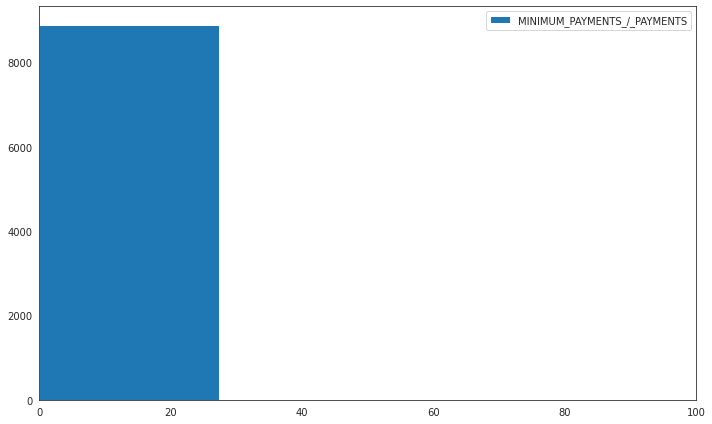

In [47]:
import utils2
from importlib import reload
reload(utils2)
from utils2 import *

df['MINIMUM_PAYMENTS_/_PAYMENTS'] = df['MINIMUM_PAYMENTS'] / df['PAYMENTS']
#imputing to zero 'MINIMUM_PAYMENTS_/_PAYMENTS' observations where 'PAYMENTS' being equal to zero causes division by zero nan
df.fillna(0, inplace = True)
viz0 = Viz(df)
viz0.make_hist('MINIMUM_PAYMENTS_/_PAYMENTS', num_bins = 50, xlim = (0,100))